In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

In [2]:
# Replace 'your_clickbait_dataset.csv' with the path to your dataset
dataset = pd.read_csv('clickbait_data.csv')

# Display information about the dataset
print(dataset.head())

                                            headline  clickbait
0                                 Should I Get Bings          1
1      Which TV Female Friend Group Do You Belong In          1
2  The New "Star Wars: The Force Awakens" Trailer...          1
3  This Vine Of New York On "Celebrity Big Brothe...          1
4  A Couple Did A Stunning Photo Shoot With Their...          1


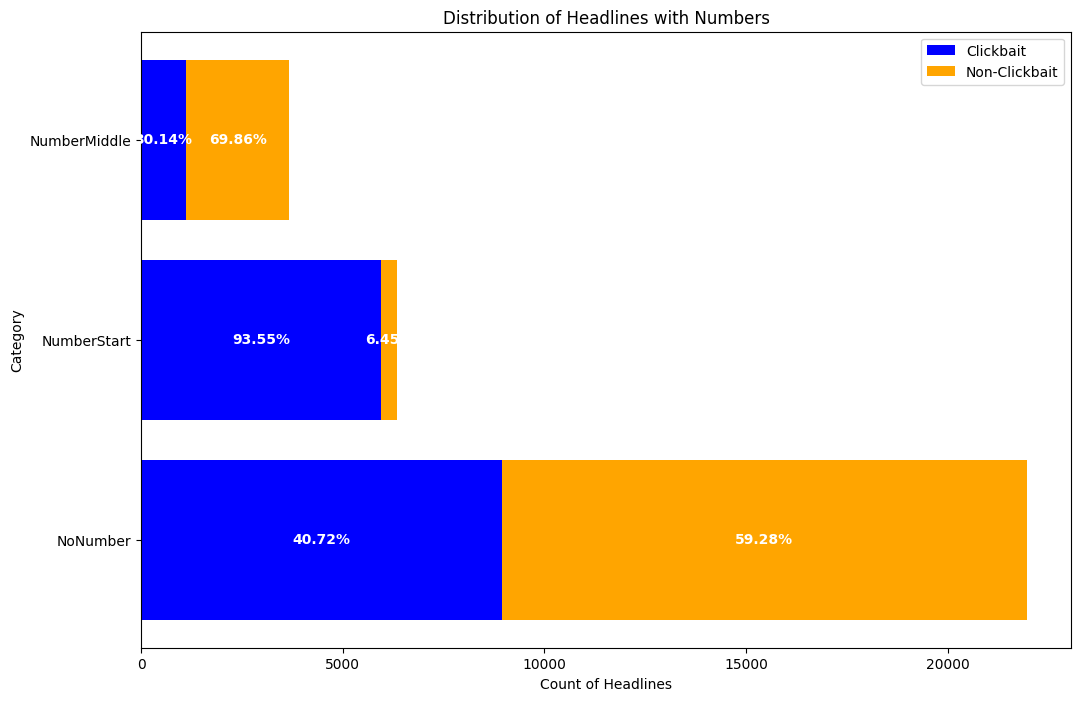

In [3]:
import matplotlib.pyplot as plt

# Calculate the total number of headlines
total_headlines = len(dataset)

# Calculate the number of clickbait and non-clickbait headlines
total_clickbait = dataset['clickbait'].sum()
total_non_clickbait = total_headlines - total_clickbait

# Calculate the number of headlines with numbers at the start and in the middle using regex
number_start_clickbait = dataset[dataset['headline'].str.match(r'^\d+') & (dataset['clickbait'] == 1)].shape[0]
number_start_non_clickbait = dataset[dataset['headline'].str.match(r'^\d+') & (dataset['clickbait'] == 0)].shape[0]
number_middle_clickbait = dataset[dataset['headline'].str.contains(r'\d+') & ~dataset['headline'].str.match(r'^\d+') & (dataset['clickbait'] == 1)].shape[0]
number_middle_non_clickbait = dataset[dataset['headline'].str.contains(r'\d+') & ~dataset['headline'].str.match(r'^\d+') & (dataset['clickbait'] == 0)].shape[0]

# Calculate the number of headlines without numbers
no_number_clickbait = total_clickbait - (number_start_clickbait + number_middle_clickbait)
no_number_non_clickbait = total_non_clickbait - (number_start_non_clickbait + number_middle_non_clickbait)

# Calculate the counts
counts = {
    'NumberStart_Clickbait': number_start_clickbait,
    'NumberStart_NonClickbait': number_start_non_clickbait,
    'NumberMiddle_Clickbait': number_middle_clickbait,
    'NumberMiddle_NonClickbait': number_middle_non_clickbait,
    'NoNumber_Clickbait': no_number_clickbait,
    'NoNumber_NonClickbait': no_number_non_clickbait
}

# Calculate the percentages based on the found amounts
percentages = {
    'NumberStart_Clickbait': (number_start_clickbait / (number_start_clickbait + number_start_non_clickbait)) * 100,
    'NumberStart_NonClickbait': (number_start_non_clickbait / (number_start_clickbait + number_start_non_clickbait)) * 100,
    'NumberMiddle_Clickbait': (number_middle_clickbait / (number_middle_clickbait + number_middle_non_clickbait)) * 100,
    'NumberMiddle_NonClickbait': (number_middle_non_clickbait / (number_middle_clickbait + number_middle_non_clickbait)) * 100,
    'NoNumber_Clickbait': (no_number_clickbait / (no_number_clickbait + no_number_non_clickbait)) * 100,
    'NoNumber_NonClickbait': (no_number_non_clickbait / (no_number_clickbait + no_number_non_clickbait)) * 100
}

# Plot the counts and percentages
labels = ['NoNumber', 'NumberStart', 'NumberMiddle']
clickbait_counts = [counts['NoNumber_Clickbait'], counts['NumberStart_Clickbait'], counts['NumberMiddle_Clickbait']]
non_clickbait_counts = [counts['NoNumber_NonClickbait'], counts['NumberStart_NonClickbait'], counts['NumberMiddle_NonClickbait']]
clickbait_percentages = [percentages['NoNumber_Clickbait'], percentages['NumberStart_Clickbait'], percentages['NumberMiddle_Clickbait']]
non_clickbait_percentages = [percentages['NoNumber_NonClickbait'], percentages['NumberStart_NonClickbait'], percentages['NumberMiddle_NonClickbait']]

fig, ax = plt.subplots(figsize=(12, 8))

# Plot counts
ax.barh(labels, clickbait_counts, color='blue', label='Clickbait')
ax.barh(labels, non_clickbait_counts, color='orange', left=clickbait_counts, label='Non-Clickbait')

# Plot percentages
for i, label in enumerate(labels):
    ax.text(clickbait_counts[i] / 2, i, f'{clickbait_percentages[i]:.2f}%', va='center', ha='center', color='white', fontweight='bold')
    ax.text(clickbait_counts[i] + non_clickbait_counts[i] / 2, i, f'{non_clickbait_percentages[i]:.2f}%', va='center', ha='center', color='white', fontweight='bold')

ax.set_title('Distribution of Headlines with Numbers')
ax.set_xlabel('Count of Headlines')
ax.set_ylabel('Category')
ax.legend()
plt.show()

In [4]:
import re

def add_number_columns(headline: str) -> pd.Series:
    # Add columns for headlines with no numbers, numbers at the start, and numbers in the middle
    no_number = not bool(re.search(r'\d+', headline))
    number_start = bool(re.match(r'^\d+', headline))
    number_middle = bool(re.search(r'\d+', headline) and not number_start)
    
    return pd.Series([no_number, number_start, number_middle])

# Apply the add_number_columns function to each headline in the dataset
dataset[['NoNumber', 'NumberStart', 'NumberMiddle']] = dataset['headline'].apply(add_number_columns)

# Display the modified dataset
print(dataset.head())

                                            headline  clickbait  NoNumber  \
0                                 Should I Get Bings          1      True   
1      Which TV Female Friend Group Do You Belong In          1      True   
2  The New "Star Wars: The Force Awakens" Trailer...          1      True   
3  This Vine Of New York On "Celebrity Big Brothe...          1      True   
4  A Couple Did A Stunning Photo Shoot With Their...          1      True   

   NumberStart  NumberMiddle  
0        False         False  
1        False         False  
2        False         False  
3        False         False  
4        False         False  


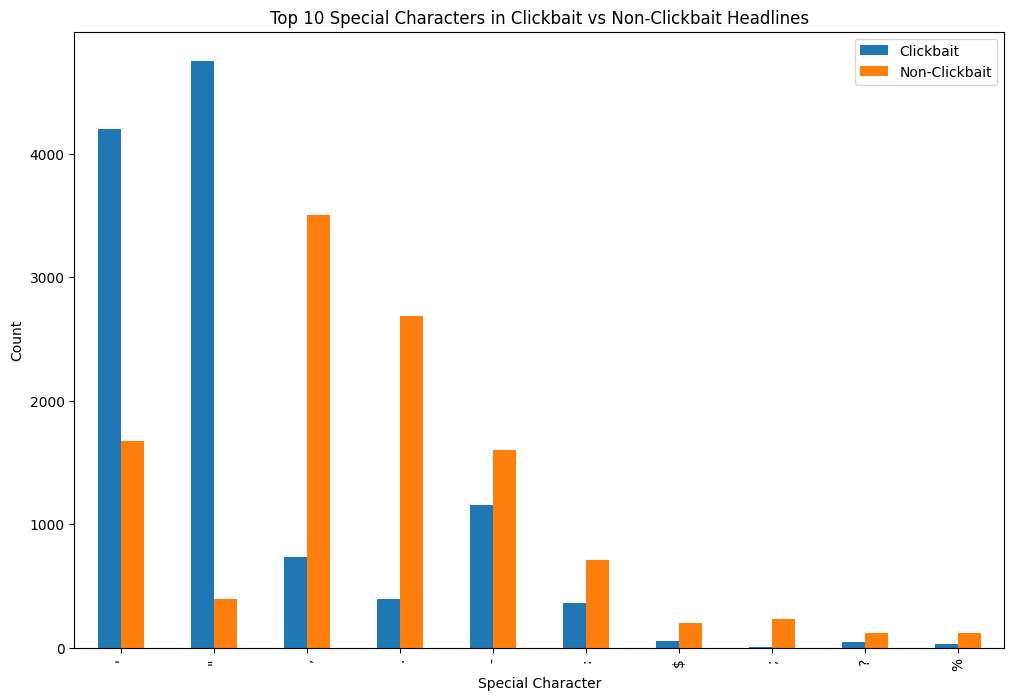

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract special characters from headlines
def extract_special_chars(headlines):
    special_chars = []
    for headline in headlines:
        special_chars.extend(re.findall(r'[^\w\s]', headline))
    return special_chars

# Separate clickbait and non-clickbait headlines
clickbait_headlines = dataset[dataset['clickbait'] == 1]['headline']
non_clickbait_headlines = dataset[dataset['clickbait'] == 0]['headline']

# Flatten the lists of special characters
clickbait_special_chars_flat = extract_special_chars(clickbait_headlines)
non_clickbait_special_chars_flat = extract_special_chars(non_clickbait_headlines)

# Count the occurrences of each special character
clickbait_special_chars_count = Counter(clickbait_special_chars_flat)
non_clickbait_special_chars_count = Counter(non_clickbait_special_chars_flat)

# Combine the counts into a DataFrame for easier plotting
special_chars_df = pd.DataFrame({
    'Character': list(set(clickbait_special_chars_flat + non_clickbait_special_chars_flat)),
    'Clickbait': [clickbait_special_chars_count[char] for char in set(clickbait_special_chars_flat + non_clickbait_special_chars_flat)],
    'Non-Clickbait': [non_clickbait_special_chars_count[char] for char in set(clickbait_special_chars_flat + non_clickbait_special_chars_flat)]
})

# Sort the DataFrame by the total count of each character
special_chars_df['Total'] = special_chars_df['Clickbait'] + special_chars_df['Non-Clickbait']
special_chars_df = special_chars_df.sort_values(by='Total', ascending=False).head(10)

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))
special_chars_df.plot(kind='bar', x='Character', y=['Clickbait', 'Non-Clickbait'], ax=ax)
plt.title('Top 10 Special Characters in Clickbait vs Non-Clickbait Headlines')
plt.xlabel('Special Character')
plt.ylabel('Count')
plt.show()

In [6]:
def add_special_character_columns(headline: str) -> pd.Series:
    """
    Add columns for special characters '-', '=', "'", and '.'.
    These characters were chosen because they are the top 4 special characters
    found in clickbait and non-clickbait headlines, as shown in the plot above.
    """
    has_minus = '-' in headline
    has_equals = '=' in headline
    has_apostrophe = "'" in headline
    has_period = '.' in headline
    
    return pd.Series([has_minus, has_equals, has_apostrophe, has_period])

# Apply the add_special_character_columns function to each headline in the dataset
dataset[['HasMinus', 'HasEquals', 'HasApostrophe', 'HasPeriod']] = dataset['headline'].apply(add_special_character_columns)

# Display the modified dataset
print(dataset.head())

                                            headline  clickbait  NoNumber  \
0                                 Should I Get Bings          1      True   
1      Which TV Female Friend Group Do You Belong In          1      True   
2  The New "Star Wars: The Force Awakens" Trailer...          1      True   
3  This Vine Of New York On "Celebrity Big Brothe...          1      True   
4  A Couple Did A Stunning Photo Shoot With Their...          1      True   

   NumberStart  NumberMiddle  HasMinus  HasEquals  HasApostrophe  HasPeriod  
0        False         False     False      False          False      False  
1        False         False     False      False          False      False  
2        False         False     False      False          False      False  
3        False         False     False      False          False      False  
4        False         False     False      False          False      False  


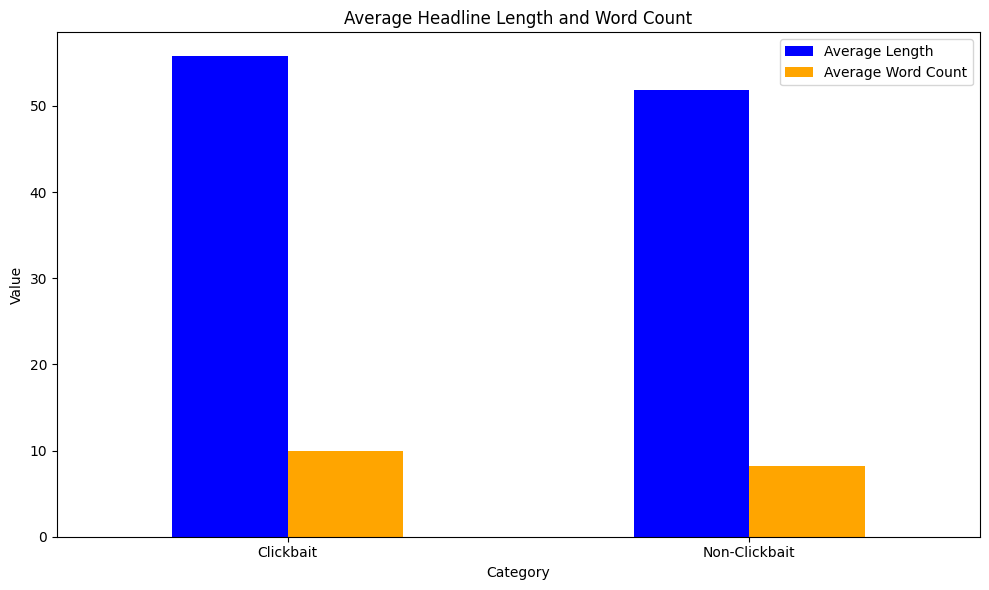

In [7]:
import matplotlib.pyplot as plt

# Calculate the average length and word count of clickbait and non-clickbait headlines
avg_length_clickbait = dataset[dataset['clickbait'] == 1]['headline'].str.len().mean()
avg_length_non_clickbait = dataset[dataset['clickbait'] == 0]['headline'].str.len().mean()
avg_word_count_clickbait = dataset[dataset['clickbait'] == 1]['headline'].str.split().apply(len).mean()
avg_word_count_non_clickbait = dataset[dataset['clickbait'] == 0]['headline'].str.split().apply(len).mean()

# Create a DataFrame for plotting
length_wordcount_df = pd.DataFrame({
    'Category': ['Clickbait', 'Non-Clickbait'],
    'Average Length': [avg_length_clickbait, avg_length_non_clickbait],
    'Average Word Count': [avg_word_count_clickbait, avg_word_count_non_clickbait]
})

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))

# Plot average length and average word count
length_wordcount_df.plot(kind='bar', x='Category', y=['Average Length', 'Average Word Count'], ax=ax, color=['blue', 'orange'])
ax.set_title('Average Headline Length and Word Count')
ax.set_ylabel('Value')
ax.set_xlabel('Category')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Too similar, we will try something else

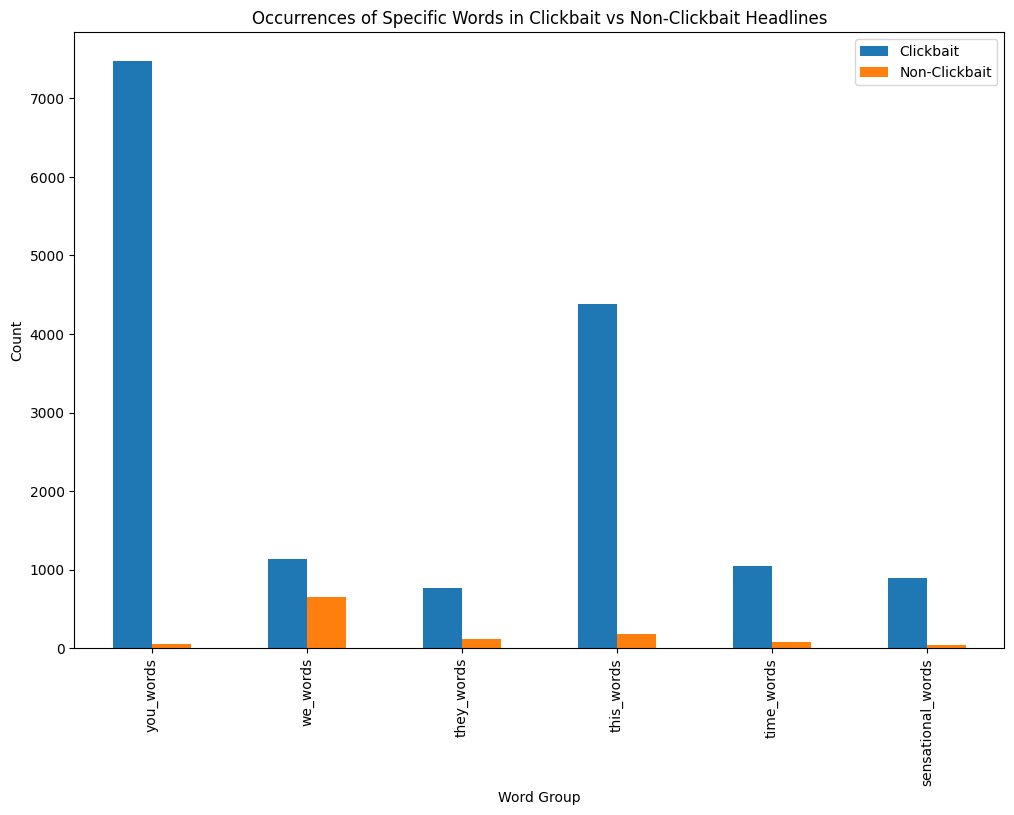

In [8]:
# Define the words to check
words = {
    'you_words': ['you', 'your', 'yours'],
    'we_words': ['we', 'us', 'our', 'ours'],
    'they_words': ['they', 'them', 'their', 'theirs'],
    'this_words': ['this', 'that', 'these', 'those'],
    'time_words': ['now', 'here', 'today', 'why'],
    'sensational_words': ['should', 'only', 'unbelievable', 'shock']
}

# Initialize a dictionary to store the counts
word_counts = {key: {'Clickbait': 0, 'Non-Clickbait': 0} for key in words.keys()}

# Count the occurrences of each word in clickbait and non-clickbait headlines
for key, word_list in words.items():
    for word in word_list:
        word_counts[key]['Clickbait'] += dataset[dataset['clickbait'] == 1]['headline'].str.contains(r'\b' + word + r'\b', case=False).sum()
        word_counts[key]['Non-Clickbait'] += dataset[dataset['clickbait'] == 0]['headline'].str.contains(r'\b' + word + r'\b', case=False).sum()

# Convert the counts to a DataFrame for plotting
word_counts_df = pd.DataFrame(word_counts).T
word_counts_df['Total'] = word_counts_df['Clickbait'] + word_counts_df['Non-Clickbait']

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))
word_counts_df.plot(kind='bar', y=['Clickbait', 'Non-Clickbait'], ax=ax)
plt.title('Occurrences of Specific Words in Clickbait vs Non-Clickbait Headlines')
plt.xlabel('Word Group')
plt.ylabel('Count')
plt.show()

This was a proof of concept. We will now use POS tagging to conduct a more detailed and comprehensive analysis.

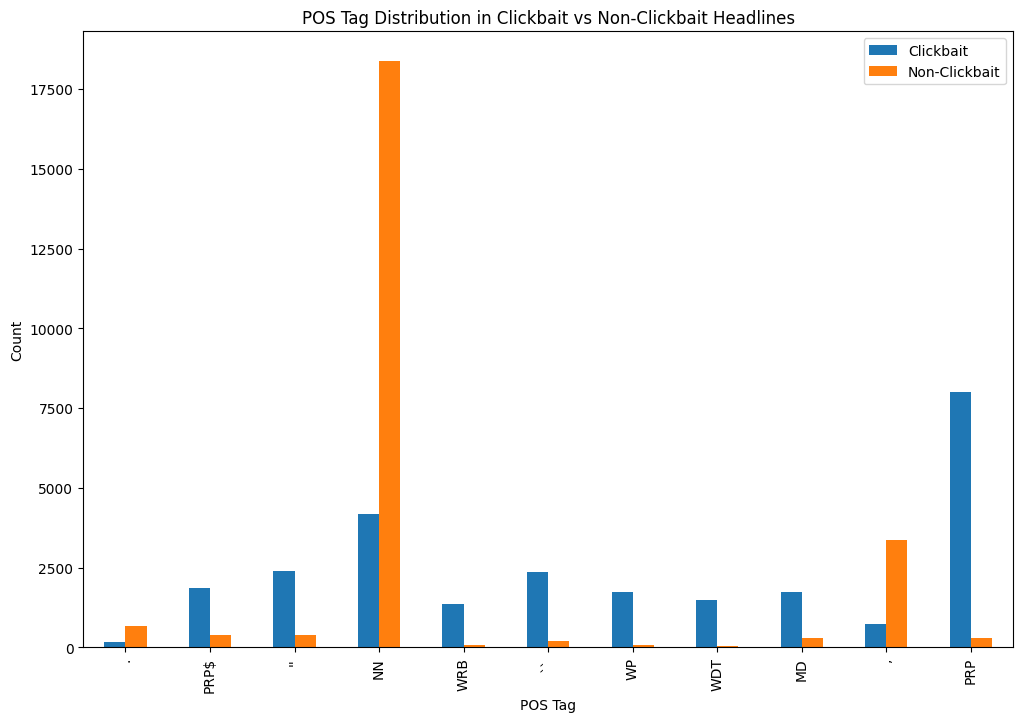

In [9]:
import nltk

# Download required resources
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('universal_tagset')

# Tokenize and POS tag each headline
tokens = dataset['headline'].apply(nltk.word_tokenize)
pos_tags = tokens.apply(lambda tokens: [tag for word, tag in nltk.pos_tag(tokens)])

# Count POS tags for clickbait and non-clickbait headlines
clickbait_pos_counts = pos_tags[dataset['clickbait'] == 1].explode().value_counts()
non_clickbait_pos_counts = pos_tags[dataset['clickbait'] == 0].explode().value_counts()

# Combine the counts into a DataFrame for easier plotting
pos_counts_df = pd.DataFrame({
    'POS Tag': list(set(clickbait_pos_counts.index).union(set(non_clickbait_pos_counts.index))),
    'Clickbait': [clickbait_pos_counts.get(tag, 0) for tag in set(clickbait_pos_counts.index).union(set(non_clickbait_pos_counts.index))],
    'Non-Clickbait': [non_clickbait_pos_counts.get(tag, 0) for tag in set(clickbait_pos_counts.index).union(set(non_clickbait_pos_counts.index))]
})

# Calculate the percentage difference
pos_counts_df['Percentage Difference'] = abs((pos_counts_df['Clickbait'] - pos_counts_df['Non-Clickbait']) / (pos_counts_df['Clickbait'] + pos_counts_df['Non-Clickbait']) * 100)
# Filter out rows with a percentage difference smaller than 60% and at least 500 datapoints
pos_counts_df = pos_counts_df[(pos_counts_df['Percentage Difference'] > 60) & ((pos_counts_df['Clickbait'] + pos_counts_df['Non-Clickbait']) >= 500)]

# Drop the no longer needed columns
pos_counts_df = pos_counts_df.drop(columns=['Percentage Difference'])

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))
pos_counts_df.plot(kind='bar', x='POS Tag', y=['Clickbait', 'Non-Clickbait'], ax=ax)
plt.title('POS Tag Distribution in Clickbait vs Non-Clickbait Headlines')
plt.xlabel('POS Tag')
plt.ylabel('Count')
plt.show()

In [10]:
# Define the POS tags and their descriptions
pos_tags_dict = {
    'CC': 'coordinating conjunction',
    'CD': 'cardinal digit',
    'DT': 'determiner',
    'EX': 'existential there',
    'FW': 'foreign word',
    'IN': 'preposition/subordinating conjunction',
    'JJ': 'adjective',
    'JJR': 'adjective, comparative',
    'JJS': 'adjective, superlative',
    'LS': 'list marker',
    'MD': 'modal',
    'NN': 'noun, singular',
    'NNS': 'noun plural',
    'NNP': 'proper noun, singular',
    'NNPS': 'proper noun, plural',
    'PDT': 'predeterminer',
    'POS': 'possessive ending',
    'PRP': 'personal pronoun',
    'PRP$': 'possessive pronoun',
    'RB': 'adverb',
    'RBR': 'adverb, comparative',
    'RBS': 'adverb, superlative',
    'RP': 'particle',
    'TO': 'to',
    'UH': 'interjection',
    'VB': 'verb, base form',
    'VBD': 'verb, past tense',
    'VBG': 'verb, gerund/present participle',
    'VBN': 'verb, past participle',
    'VBP': 'verb, sing. present, non-3d',
    'VBZ': 'verb, 3rd person sing. present',
    'WDT': 'wh-determiner',
    'WP': 'wh-pronoun',
    'WP$': 'possessive wh-pronoun',
    'WRB': 'wh-adverb'
}

# Create a DataFrame to store the POS tag columns
pos_columns = pd.DataFrame(index=dataset.index)

# Add columns for each POS tag and initialize them to False
for tag, description in pos_tags_dict.items():
    pos_columns[description] = False

# Set the corresponding POS tag columns to True for each headline
for i, tags in enumerate(pos_tags):
    for tag in tags:
        if tag in pos_tags_dict:
            pos_columns.at[i, pos_tags_dict[tag]] = True

# Add the POS tag columns to the original dataset
dataset = pd.concat([dataset, pos_columns], axis=1)

# Display the modified DataFrame
print(dataset.head())

                                            headline  clickbait  NoNumber  \
0                                 Should I Get Bings          1      True   
1      Which TV Female Friend Group Do You Belong In          1      True   
2  The New "Star Wars: The Force Awakens" Trailer...          1      True   
3  This Vine Of New York On "Celebrity Big Brothe...          1      True   
4  A Couple Did A Stunning Photo Shoot With Their...          1      True   

   NumberStart  NumberMiddle  HasMinus  HasEquals  HasApostrophe  HasPeriod  \
0        False         False     False      False          False      False   
1        False         False     False      False          False      False   
2        False         False     False      False          False      False   
3        False         False     False      False          False      False   
4        False         False     False      False          False      False   

   coordinating conjunction  ...  verb, base form  verb, past 

In [11]:
# Drop the 'headline' column before calculating the correlation matrix
correlation_matrix = dataset.drop(columns=['headline']).corr()

# Get the correlation of each feature with the 'clickbait' column
correlation_with_clickbait = correlation_matrix['clickbait'].abs().sort_values(ascending=False)

# Remove the 'clickbait' column from the list
correlation_with_clickbait = correlation_with_clickbait.drop('clickbait')

# Get the top 20 features with the highest correlation
top_20_features = correlation_with_clickbait.index[:6]

# Display the top 5 features and their correlation values
print("Top 20 Features with Highest Correlation to Clickbait:")
print(correlation_with_clickbait[top_20_features])

Top 20 Features with Highest Correlation to Clickbait:
personal pronoun    0.498257
NumberStart         0.433780
noun, singular      0.387970
determiner          0.327455
NoNumber            0.274580
cardinal digit      0.247906
Name: clickbait, dtype: float64


In [12]:
# Keep only the top 5 features + 'clickbait' and 'headline' in the dataset
dataset = dataset[['headline', 'clickbait'] + list(correlation_with_clickbait.index[:6])]

# Display the modified dataset
print(dataset.head())

                                            headline  clickbait  \
0                                 Should I Get Bings          1   
1      Which TV Female Friend Group Do You Belong In          1   
2  The New "Star Wars: The Force Awakens" Trailer...          1   
3  This Vine Of New York On "Celebrity Big Brothe...          1   
4  A Couple Did A Stunning Photo Shoot With Their...          1   

   personal pronoun  NumberStart  noun, singular  determiner  NoNumber  \
0              True        False           False       False      True   
1              True        False            True       False      True   
2              True        False            True        True      True   
3             False        False           False        True      True   
4              True        False            True        True      True   

   cardinal digit  
0           False  
1           False  
2           False  
3           False  
4           False  


In [13]:
from sklearn.model_selection import GridSearchCV

# Define the features and target variable
features = dataset.drop(columns=['headline', 'clickbait'])
target = dataset['clickbait']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10],
    'min_samples_split': [2, 5, 10],
    'ccp_alpha': [0.0, 0.1, 0.2],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Score: {best_score:.2f}')

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Cross-Validation Score: 0.85


In [14]:
# Train the classifier with the best parameters
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Display the decision tree
tree_rules = export_text(best_clf, feature_names=list(features.columns), max_depth=10)
print(tree_rules)

Accuracy: 0.85
|--- personal pronoun <= 0.50
|   |--- NumberStart <= 0.50
|   |   |--- determiner <= 0.50
|   |   |   |--- noun, singular <= 0.50
|   |   |   |   |--- cardinal digit <= 0.50
|   |   |   |   |   |--- NoNumber <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- NoNumber >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- cardinal digit >  0.50
|   |   |   |   |   |--- NoNumber <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- NoNumber >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- noun, singular >  0.50
|   |   |   |   |--- NoNumber <= 0.50
|   |   |   |   |   |--- cardinal digit <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- cardinal digit >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- NoNumber >  0.50
|   |   |   |   |   |--- cardinal digit <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- cardinal digit >  0.50
|   |   |   |   |   |   

In [17]:
# Refining the output of the decision tree into a function: removed redundant checks and simplified the structure

def rule_based_clickbait_classifier(NumberStart, PRP, NoNumber, DT, NN):

    # 'DT': 'determiner'
    # 'NN': 'noun, singular'
    # 'PRP': 'personal pronoun'

    # NoNumber is not used in the decision tree (only redundant checks)

    if not PRP:  # personal pronoun == False
        if not NumberStart:  # == False
            if not DT:  # determiner == False
                return 0
            else:  # determiner == True
                if not NN:  # noun, singular == False
                    return 1
                else:  # noun, singular == True
                    return 0
        else:  # numberStart == True
            return 1
    else:  # personal pronoun == True
        return 1

In [18]:
from sklearn.metrics import precision_score

# Apply the classify_headline function to each row in the dataset
predictions = dataset.apply(lambda row: rule_based_clickbait_classifier(row['NumberStart'], row['personal pronoun'], row['NoNumber'], row['determiner'], row['noun, singular']), axis=1)

# Calculate the precision of the predictions
precision = precision_score(dataset['clickbait'], predictions)
print(f'Precision: {precision:.2f}')

Precision: 0.87
